In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.optimizers import SGD
from numpy.random import uniform
import keras
from tensorflow.keras import layers

2023-06-16 00:37:09.380669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 00:37:10.024763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
def generate_mixed_shape(shape1, shape2, shape3, shape4):
    shape = []
    shape.extend(shape1[:15].tolist())
    shape.extend(shape2[15:30].tolist())
    shape.extend(shape3[30:45].tolist())
    shape.extend(shape4[45:60].tolist())
    return pd.DataFrame([shape])

In [41]:
def generate_noisy_shape(shape):
    noisyShape = []
    for val in shape:
        noisyShape.append(val + uniform(-0.3, 0.3))
    return pd.DataFrame([noisyShape])

In [42]:
symbol_data = pd.read_csv("data/dataset1_fixed.csv", header=None)
X = symbol_data.iloc[:, :-1]
Y = symbol_data.iloc[:, -1:]
Y = Y.replace("Time", 0)
Y = Y.replace("Wind", 1)
Y = Y.replace("Air", 1)
Y = Y.replace("Fire", 2)
Y = Y.replace("Earth", 3)
Y = Y.replace("Water", 4)
Y = Y.replace("Lightning", 5)

for i in range(100):
    random_symbols = X.sample(n=4)
    X = pd.concat([X, generate_mixed_shape(random_symbols.iloc[0], random_symbols.iloc[1], random_symbols.iloc[2],
                                           random_symbols.iloc[3])])
    Y = pd.concat([Y, pd.DataFrame([6], columns=[60])])

for i in range(100):
    random_symbol = X.sample(n=1)
    X = pd.concat([X, pd.DataFrame(generate_noisy_shape(random_symbol.iloc[0]))])
    Y = pd.concat([Y, pd.DataFrame([6], columns=[60])])

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.20)

y_test = y_test.values.flatten().astype("float64")
y_train = y_train.values.flatten().astype("float64")

In [43]:
x_train_3d = [np.array(x_train[i]).reshape(-1, 3) for i in range(len(x_train))]
x_test_3d = [np.array(x_test[i]).reshape(-1, 3) for i in range(len(x_test))]

x_train_3d = tf.stack(x_train_3d)
x_test_3d = tf.stack(x_test_3d)

In [44]:
print(x_test_3d)

tf.Tensor(
[[[0.000000e+00 0.000000e+00 1.278099e-03]
  [5.658362e-02 1.278713e-01 1.188829e-03]
  [1.075785e-01 2.522959e-01 1.040315e-03]
  ...
  [9.066686e-01 1.301902e-02 2.608897e-03]
  [9.066686e-01 1.301902e-02 2.608897e-03]
  [9.066686e-01 1.301902e-02 2.608897e-03]]

 [[2.162686e-01 1.000000e+00 0.000000e+00]
  [1.594829e-01 9.266521e-01 1.321550e-03]
  [1.184696e-01 8.448945e-01 2.582021e-03]
  ...
  [1.227485e-01 0.000000e+00 3.577395e-03]
  [1.258600e-01 6.283163e-02 4.108367e-03]
  [1.258600e-01 6.283163e-02 4.108367e-03]]

 [[3.280741e-01 1.000000e+00 2.167617e-03]
  [3.054087e-01 9.182222e-01 3.658641e-03]
  [2.753298e-01 8.400385e-01 5.194055e-03]
  ...
  [5.530991e-03 0.000000e+00 2.590099e-03]
  [0.000000e+00 7.131944e-03 2.598170e-03]
  [0.000000e+00 7.131944e-03 2.598170e-03]]

 ...

 [[0.000000e+00 0.000000e+00 2.068214e-04]
  [2.089733e-02 1.391858e-01 1.874837e-04]
  [8.132624e-02 2.691526e-01 1.777664e-04]
  ...
  [9.189277e-01 2.470754e-01 6.202909e-04]
  [9.18

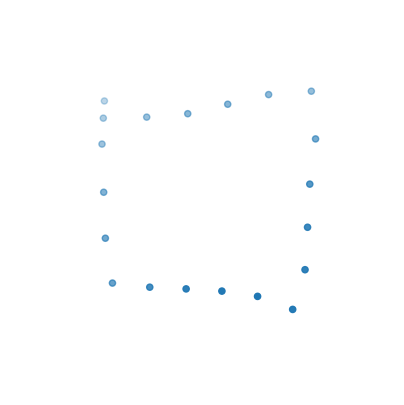

label:  3.0


In [45]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = x_train_3d[4]
clas = y_train[4]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()
print("label: ", clas)

In [46]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [47]:
NUM_POINTS = 20
NUM_CLASSES = 5
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(x_test_3d)).batch(BATCH_SIZE)

In [48]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [49]:
def conv_bn(x, filters, subfix):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name="conv_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    return layers.Activation("relu", name="relu_" + subfix)(x)


def dense_bn(x, filters, subfix):
    x = layers.Dense(filters, name="dense_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    return layers.Activation("relu", name="relu_" + subfix)(x)

In [50]:
class OrthogonalRegularizerTest(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': float(self.num_features), 'l2reg': float(self.l2reg)}

In [51]:
type(tf.eye(3))

tensorflow.python.framework.ops.EagerTensor

In [52]:
def tnet(inputs, num_features, subfix):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = tf.keras.regularizers.OrthogonalRegularizer(factor=0.01, mode="columns")
    # reg = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    reg = OrthogonalRegularizerTest(num_features)

    x = conv_bn(inputs, 32, subfix + "_1")
    x = conv_bn(x, 64, subfix + "_2")
    x = conv_bn(x, 512, subfix + "_3")
    x = layers.GlobalMaxPooling1D(name="maxpool_" + subfix)(x)
    x = dense_bn(x, 256, subfix + "_4")
    x = dense_bn(x, 128, subfix + "_5")
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
        name="T_" + subfix,
    )(x)
    feat_T = layers.Reshape((num_features, num_features), name="T_reshape_" + subfix)(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1), name="T_dot_" + subfix)([inputs, feat_T])

In [53]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3, "tnet1")
x = conv_bn(x, 32, "1")
x = conv_bn(x, 32,  "2")
x = tnet(x, 32, "tnet2")
x = conv_bn(x, 32, "3")
x = conv_bn(x, 64, "4")
x = conv_bn(x, 512, "5")
x = layers.GlobalMaxPooling1D(name="maxpool1")(x)
x = dense_bn(x, 256, "6")
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128, "7")
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 3)]      0           []                               
                                                                                                  
 conv_tnet1_1 (Conv1D)          (None, 20, 32)       128         ['input_4[0][0]']                
                                                                                                  
 bn_tnet1_1 (BatchNormalization  (None, 20, 32)      128         ['conv_tnet1_1[0][0]']           
 )                                                                                                
                                                                                                  
 relu_tnet1_1 (Activation)      (None, 20, 32)       0           ['bn_tnet1_1[0][0]']      

In [54]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30


2023-06-16 00:54:32.629189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1199,20,3]
	 [[{{node Placeholder/_0}}]]
2023-06-16 00:54:32.629579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1199]
	 [[{{node Placeholder/_1}}]]


37/38 [============================>.] - ETA: 0s - loss: 3.5285 - sparse_categorical_accuracy: 0.3716

2023-06-16 00:54:37.886198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [300]
	 [[{{node Placeholder/_1}}]]
2023-06-16 00:54:37.886415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [300]
	 [[{{node Placeholder/_1}}]]


38/38 [==============================] - 6s 70ms/step - loss: 3.5135 - sparse_categorical_accuracy: 0.3728 - val_loss: 4.4844 - val_sparse_categorical_accuracy: 0.6767
Epoch 2/30
38/38 [==============================] - 2s 41ms/step - loss: 2.3045 - sparse_categorical_accuracy: 0.6747 - val_loss: 4.4437 - val_sparse_categorical_accuracy: 0.7400
Epoch 3/30
38/38 [==============================] - 2s 44ms/step - loss: 2.0504 - sparse_categorical_accuracy: 0.7415 - val_loss: 838487296.0000 - val_sparse_categorical_accuracy: 0.6433
Epoch 4/30
38/38 [==============================] - 2s 45ms/step - loss: 1.8270 - sparse_categorical_accuracy: 0.8057 - val_loss: 2.4788 - val_sparse_categorical_accuracy: 0.6600
Epoch 5/30
38/38 [==============================] - 2s 52ms/step - loss: 1.7250 - sparse_categorical_accuracy: 0.8407 - val_loss: 1.8956 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/30
38/38 [==============================] - 2s 52ms/step - loss: 1.6563 - sparse_categorical_accurac

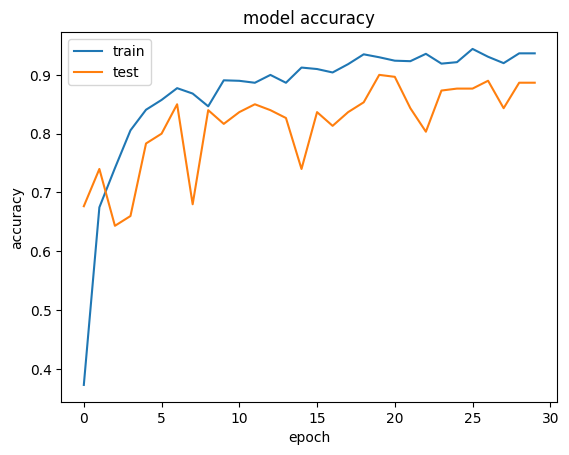

In [55]:
# show history plot
plt.plot(model.history.history["sparse_categorical_accuracy"])
plt.plot(model.history.history["val_sparse_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

10/10 [==============================] - 1s 16ms/step
[[ 7  6  3  6  9  5  8]
 [10 11  5  9  9 10  5]
 [ 5  4  0  0  5  6  1]
 [ 4  4  2  4 13  6  6]
 [ 8 14  2  3  9  6  3]
 [ 4 12  4  5 12  5  6]
 [ 6  5  4  4 13 10  2]]


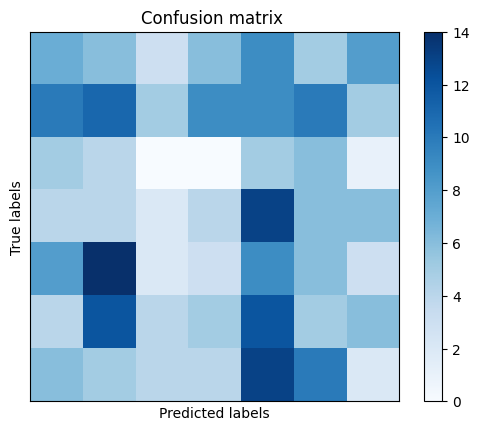

In [56]:
from sklearn.metrics import confusion_matrix

# confusion matrix
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
cm = confusion_matrix(y_true, y_pred)
print(cm)
# plot
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title("Confusion matrix ")
plt.colorbar()
plt.show()

2023-06-16 00:55:52.596934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [300]
	 [[{{node Placeholder/_1}}]]
2023-06-16 00:55:52.597385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [300,20,3]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 415ms/step


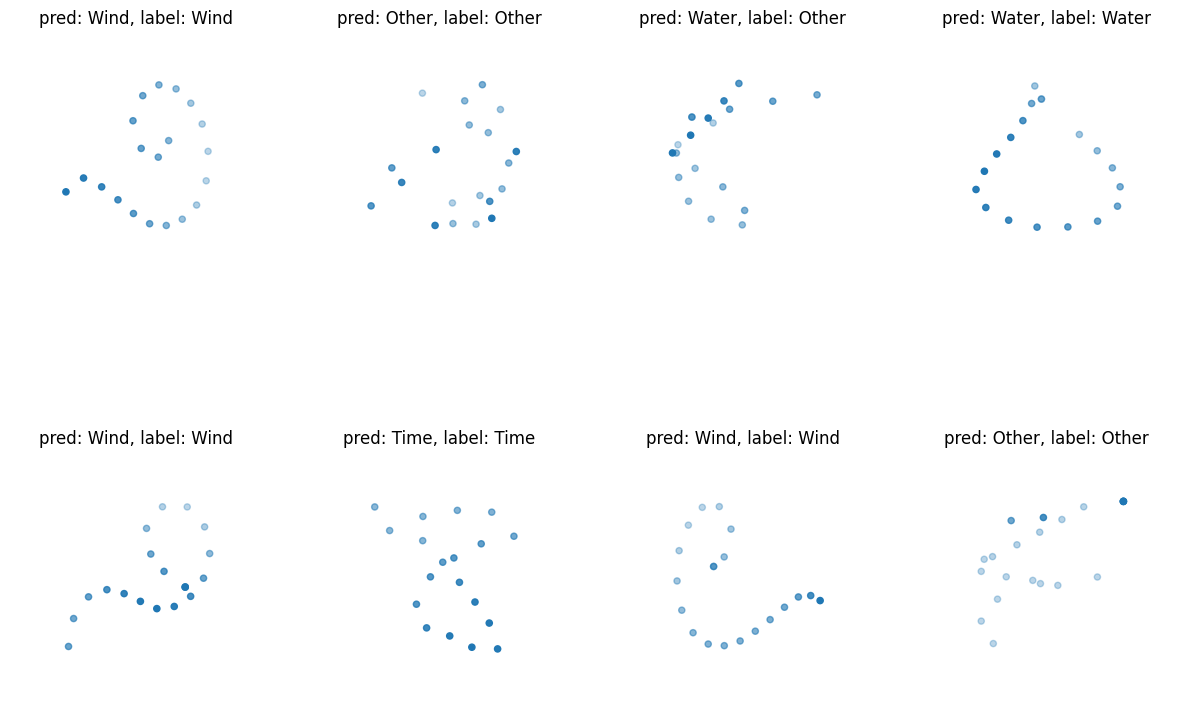

In [57]:
class_map = {}
class_map[0] = "Time"
class_map[1] = "Wind"
class_map[2] = "Fire"
class_map[3] = "Earth"
class_map[4] = "Water"
class_map[5] = "Lightning"
class_map[6] = "Other"

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
    ax.view_init(elev=90, azim=0, roll=90)
plt.show()


In [58]:
# save with custom objects
model.save('model_3d_with_other')

model.save('model_3d_with_other.h5', save_format='h5')

2023-06-16 00:56:06.291040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,9]
	 [[{{node inputs}}]]
2023-06-16 00:56:06.366783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-06-16 00:56:06.409082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-16 00:56:

INFO:tensorflow:Assets written to: model_3d_with_other/assets


INFO:tensorflow:Assets written to: model_3d_with_other/assets


In [59]:
model.evaluate(test_dataset)

10/10 [==============================] - 0s 19ms/step - loss: 1.7570 - sparse_categorical_accuracy: 0.8867


[1.7570210695266724, 0.8866666555404663]

In [60]:
!python -m tf2onnx.convert --saved-model model_3d_with_other --output model_3d_with_other.onnx

2023-06-16 00:56:52.479840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/aster/miniconda3/envs/ComputerVisionProject/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-06-16 00:56:54,286 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-06-16 00:56:56,204 - INFO - Signatures found in model: [serving_default].
2023-06-16 00:56:56,204 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-06-16 00:56:56,205 - INFO - Output names: ['outputs']
2023-06-16 00:56:56,683 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.14.0/8f8d49
2023-06-16 00:56:56,683 - INFO - Using opset <onnx, 15>
2023-06-16 00:56:56,718 - INFO - Computed 0 values for constant folding
2023-06-16 00:56:56,798 - INFO 

In [34]:
test_model = keras.models.load_model('model_3d_with_other')

In [ ]:
inverted_rune_data = pd.read_csv("InvertedRunes.csv", header=None)
inverted_runes_X = inverted_rune_data.iloc[:, :-1]

inverted_runes_Y = inverted_rune_data.iloc[:, -1:]
inverted_runes_Y = inverted_runes_Y.replace("Time", 0)
inverted_runes_Y = inverted_runes_Y.replace("Wind", 1)

inverted_runes_X_3d = [np.array(inverted_runes_X[i]).reshape(-1, 3) for i in range(len(inverted_runes_X))]
inverted_runes_X_3d = tf.stack(inverted_runes_X_3d)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = inverted_runes_X_3d[2]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()

In [ ]:
test_model = keras.models.load_model('model_3d_with_other',
                                     custom_objects={'OrthogonalRegularizerTest': OrthogonalRegularizerTest})

In [ ]:
test_model.evaluate(test_dataset)